In [65]:
### Setting up Google Colab (optional) ###
# Installing necessary packages
!pip install python-igraph
!pip install leidenalg
!pip install umap-learn
!pip install umap-learn -i https://mirrors.ustc.edu.cn/pypi/web/simple
!pip install googletrans==4.0.0-rc1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://mirrors.ustc.edu.cn/pypi/web/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [66]:
# # Getting access to Google Drive files (participants-votes.csv etc)
# from google.colab import drive
# drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [67]:
# %cd 'drive/Shareddrives/DS final project w  oli/vtaiwan/vtaiwan_csv' 

[Errno 2] No such file or directory: 'drive/Shareddrives/DS final project w  oli/vtaiwan/vtaiwan_csv'
/content/drive/Shareddrives/DS final project w  oli/vtaiwan/vtaiwan_csv


# 0. load packages and read data

In [68]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import altair as alt
from tqdm.notebook import tqdm
from textwrap import wrap
from sklearn.neighbors import kneighbors_graph

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances

import umap.umap_ as umap
# import umap

import googletrans
from pprint import pprint

# 1. preprocess data

In [69]:
#read in data
df_comments= pd.read_csv("./dataset/comments.csv")
df = pd.read_csv("./dataset/participants-votes.csv")

In [70]:
print(df_comments.shape, df.shape)

(197, 8) (1921, 203)


## filter particant w/ less than 7 votes
Including the partipants vote less than 7 votes, which would be removed from the valid voters list. There are 1921 voters, and 203 vals: including the meta data of their votes, and their opinion on each comments.

In [71]:
## obtain the number of issues for votes 
metadata_fields = ['group-id', 'n-comments', 'n-votes', 
                   'n-agree', 'n-disagree']
val_fields = [c for c in df.columns.values if c not in metadata_fields]


In [72]:
## for a row, count the number of finite values
def count_finite(row):
    finite = np.isfinite(row[val_fields]) # boolean array of whether each entry is finite
    return sum(finite) # count number of True values in `finite`


## REMOVE PARTICIPANTS WITH LESS THAN N VOTES check for each row if the number of finite values >= cutoff
def select_rows(df, threshold):
    
    number_of_votes = df.apply(count_finite, axis=1)
    valid = number_of_votes >= threshold
    
    return df[valid]

df = select_rows(df, 7)

In [73]:
metadata = df[metadata_fields]
vals = df[val_fields]
vals = vals.fillna(0)
vals = vals.sort_values("participant").reset_index(drop=True)
vals.columns 

Index(['participant', '0', '1', '2', '3', '4', '5', '6', '7', '8',
       ...
       '187', '188', '189', '190', '191', '192', '193', '194', '195', '196'],
      dtype='object', length=198)

In [74]:
print(metadata.shape, vals.shape)

(1269, 5) (1269, 198)


Including the comments being moderated out, there are 197 comments and 8 vals including the datetime, index of comments, id of author, and the general stands of this comments (agree/disagree) with the uber issue

remove statements (columns) which were moderated out

In [75]:
df_comments[df_comments["moderated"] ==1]['comment-id']

9      159
12     156
13     154
15     153
17     151
      ... 
179     13
180     14
181     15
182     16
183     17
Name: comment-id, Length: 99, dtype: int64

In [76]:
df_comments.columns

Index(['timestamp', 'datetime', 'comment-id', 'author-id', 'agrees',
       'disagrees', 'moderated', 'comment-body'],
      dtype='object')

In [77]:
df_comments["moderated"] = df_comments["moderated"].round()
statements_all_in = sorted(list(df_comments[df_comments["moderated"] ==1]['comment-id']), key = int)

vals_all_in = vals[[str(i) for i in statements_all_in]]
vals_all_in.describe()

,0,3,4,5,6,7,8,9,10,12,...,161,162,164,165,169,170,171,172,173,174
count,1269.000000,1269.000000,1269.000000,1269.000000,1269.00000,1269.000000,1269.000000,1269.000000,1269.000000,1269.000000,...,1269.000000,1269.000000,1269.000000,1269.000000,1269.000000,1269.000000,1269.000000,1269.000000,1269.000000,1269.000000
mean,0.234831,0.311269,0.222222,0.101655,0.14736,0.504334,0.367218,0.313633,-0.117415,0.156816,...,0.033097,0.013396,0.010244,0.038613,0.038613,-0.011820,-0.013396,0.052797,0.007092,0.007092
std,0.684449,0.668140,0.668897,0.688966,0.70007,0.546877,0.625986,0.632439,0.676035,0.695747,...,0.252136,0.207836,0.282042,0.259075,0.256013,0.226102,0.276259,0.259614,0.246323,0.233165
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,-1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [78]:
vals_all_in.shape

(1269, 99)

vals_all_in include 1269 participant's vote on the 99 comments

## process comment dataframe



### translate comments to english

In [79]:
# delete all rows contain URL
df_comments = df_comments[~df_comments["comment-body"].str.contains("http", case=False)]

In [80]:
# Initial
translator = googletrans.Translator()
df_comments["comment-en"] = [translator.translate(i, dest='en').text for i in tqdm(df_comments["comment-body"]) ]


  0%|          | 0/196 [00:00<?, ?it/s]

In [81]:
df_comments.head(5)

,timestamp,datetime,comment-id,author-id,agrees,disagrees,moderated,comment-body,comment-en
0,1472552518501,Tue Aug 30 17:21:58 WIB 2016,194,4413,1,0,0,Uber的出現 因服務內容明確、平台簡潔、交易程序精簡、路線糾紛減少，並有評價機制穩定服務雙...,The emergence of Uber due to clear service con...
1,1472403087787,Sun Aug 28 23:51:27 WIB 2016,187,4378,1,0,0,uber就是叫派計程車，談不上運用閒置資源或是共乘,Uber is to send a taxi.
2,1451878620176,Mon Jan 04 10:37:00 WIB 2016,183,4120,1,0,0,探討法律、稅務、安全等問題時，應先理解供需，為什麼民眾會選擇Uber？簡單說就是機會成本的選...,"When discussing issues such as law, taxation, ..."
3,1438228490557,Thu Jul 30 10:54:50 WIB 2015,138,1476,1,0,-1,Uner只不過是用多餘的時間來賺取微薄的收入，黃牌不用繳交所得稅外還有補助，那麼我們上班族都...,UNER just earns a meager income in extra time....
4,1438155033741,Wed Jul 29 14:30:33 WIB 2015,130,1960,1,0,-1,我覺得搭乘時完全不用擔心身上太多的零錢或是找不開的金額鈔票，一來可以讓司機放心身上不用帶太多...,I don't think you have to worry about too much...


### filter moderated out comments

In [82]:
moderated_out = sorted(list(df_comments.loc[df_comments["moderated"] !=1].index.array), key = int)

In [83]:
# example of moderated out comments
non_qulified_cmt = df_comments[~df_comments['comment-id'].isin(statements_all_in)].sample(5)[['comment-id', 'moderated', 'comment-body', 'comment-en']]
non_qulified_cmt

,comment-id,moderated,comment-body,comment-en
93,81,-1,我覺得還好，但如果可以開放民眾查得到會更好,"I think it's okay, but it would be better if t..."
103,91,-1,我覺得台灣放行Uber營運可以讓民眾多一個便捷的交通方式，且Uber有保障乘客許多權益機制。,I think that Taiwan's release of Uber operatio...
71,142,-1,不喜歡 Uber 的人，除了自己不坐，還應該可以要求立法叫大家都不能坐,"Those who don’t like Uber, in addition to not ..."
157,132,-1,我覺得有競爭才會有進步，政府可以針對uber哪裡不合法，需要改或討論的，我相信uber會去做...,I think there will be progress in competition....
0,194,0,Uber的出現 因服務內容明確、平台簡潔、交易程序精簡、路線糾紛減少，並有評價機制穩定服務雙...,The emergence of Uber due to clear service con...


In [84]:
# example of comments which keep
left_cmts = df_comments[df_comments['comment-id'].isin(statements_all_in)].sample(5)[['comment-id','moderated', 'comment-body', 'comment-en']]
left_cmts

,comment-id,moderated,comment-body,comment-en
17,151,1,我覺得目前管理職業客車的法規對分享經濟很不友善。應該要盡速修法，比較環保。,I think the regulations that currently manage ...
80,66,1,我覺得Uber司機開車時較不會像計程車司機亂鑽，當客人要下車時計程車會直接切換車道不顧後方來...,I think the Uber driver is less like a taxi dr...
123,165,1,"我覺得真正共乘的精神, 應該要讓司機能選擇去什麼地區的乘客一起搭乘, 否則共乘只是白牌車營業...",I think the spirit of the real co -coexistence...
84,72,1,我覺得UberX在計費上通常較計程車便宜，平均都能省下一個便當的錢。,I think Uberx is usually cheaper than taxis in...
176,12,1,Uber 是媒合平台，就像拍賣網站，屬於資訊業。,"Uber is a media platform, just like auction we..."


In [85]:
df_comments = df_comments[df_comments['comment-id'].isin(statements_all_in)]

### check high variance comments



In [86]:
def get_top_var_idx(data, n):
    arr = np.var(data.to_numpy(), axis=0)

    sorted_index_array = np.argsort(arr)[-n:]

    keys = data.columns[sorted_index_array]
    
    return keys


obtain the list of comments that derive high variances and low variances respectively

In [87]:
high_variance_cmts = get_top_var_idx(vals.drop("participant",axis=1), 10)
statements_consensus = get_top_var_idx(vals.drop("participant",axis=1), -10)

In [88]:
df_comments = df_comments[df_comments['comment-id'].isin(statements_all_in)]

### convert columnd: **datetime** to timestamp data type

In [89]:
print(type(df_comments['datetime'].iloc[0]))
df_comments['datetime'] = df_comments['datetime'].str.replace(' WIB', '')
df_comments['datetime'] = pd.to_datetime(df_comments['datetime'], infer_datetime_format=True)  
print(type(df_comments['datetime'].iloc[0]))


<class 'str'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>


# 2. analysis


**Data info**
How sparse is the dataset? How much agree, how much disagree, how much pass? Zero is 'passed' or 'did not see the comment to vote on it'. 1 is agree, -1 is disagree

In [90]:
melted = vals.melt();
all_votes = melted.count();
by_type = melted["value"].value_counts();
total_possible_votes = all_votes["value"];
total_agrees = by_type[1.0];
total_disagrees = by_type[-1.0];
total_without_vote = by_type[0.0];

print("Dimensions of matrix:", df.shape)
print("Dimensions of matrix:", vals.shape)
print("Total number of possible votes:", total_possible_votes)
print("Total number of agrees:", total_agrees)
print("Total number of disagrees:", total_disagrees)
print("Total without vote:", total_without_vote)
print("Percent sparse: ", total_without_vote / total_possible_votes,"%")

## Make sure to check how many people and votes, relative to the total matrix, you are losing given min vote threshold

Dimensions of matrix: (1269, 203)
Dimensions of matrix: (1269, 198)
Total number of possible votes: 251262
Total number of agrees: 30237
Total number of disagrees: 11661
Total without vote: 208097
Percent sparse:  0.8282072100039003 %


## cluster functions

In [91]:
def kmean_get_grouped(df, embeds, k):
    grouped_embed = KMeans(n_clusters=k, random_state=0)
    grouped_embed = grouped_embed.fit(embeds)
    labs = grouped_embed.labels_

    res_list=[]
    for i in range(k):
        key = np.where(labs == i )[0]
        idx = np.take(df.index.to_numpy(), key)
        res_list.append(df.filter(items = idx, axis=0))

    return res_list

## some graph funct

In [92]:
import numba

@numba.njit()
def sparsity_aware_dist(a, b):
    n_both_seen = len(a) - (np.isnan(a) | np.isnan(b)).sum()
    return (n_both_seen - (a == b).sum() + 1) / (n_both_seen + 2)

In [93]:
def show_embedding(space, color, title):

    fig, ax = plt.subplots(figsize=(7,5))
    plt.sca(ax)
    # NB: palette contains only 20 colors ('tab20')
    # (User needs to artificially limit communities to <20)
    ax.scatter(
        x=space[:,0],
        y=space[:,1],
        c=color,
        cmap="tab20",
        s=5
    )
    ax.set_title(title, fontsize=14)
    plt.show()
    return plt

## Full participants * comments matrix

Some things to notice about the matrix: comments are submitted over time, so participants who do not return will only have voted on the statements which were avialable when they arrived.

Long horizontal lines: participants who do return show up as a horizontal line sticking out into otherwise blank areas

Blank vertical lines: most likely statements which were moderated out of the conversation.

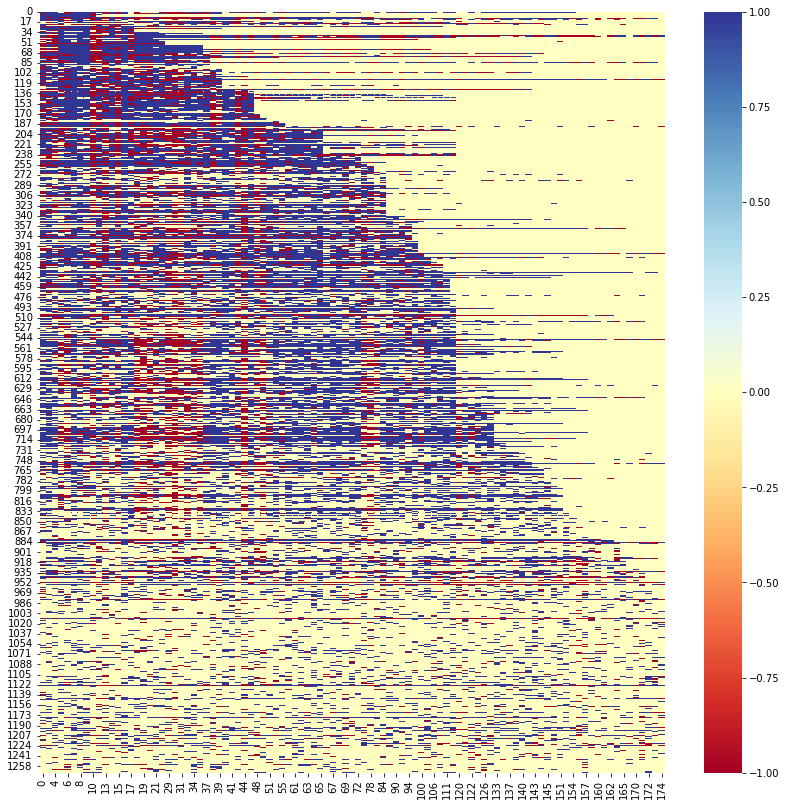

In [94]:
fig, ax = plt.subplots(figsize=(14,14))
sns.heatmap(vals_all_in, center=0, cmap="RdYlBu", ax=ax)

- The horizontal axis are comments-id from 1-197, some horizontal lines are blank for it's being moderated out. 

- The vertical axis are the participants id


## PCA

Pros: 
- Relatively computationally cheap 
- Can save embedding model to then project new data points into the reduced space. 

Cons:
- Linear reduction limits information that can be captured not as discriminably clusters as other algorithms

PCA with 2 principle components only explain approximate 30% of the variance, while explain near 80% of variance when include 20 principle components.

The graph shows that the seperation is not very boundary-clear


In [95]:
def polis_pca(dataframe, components):
    pca_object = PCA(n_components=components) ## pca is apparently different, it wants 
    pca_object = pca_object.fit(dataframe.T) ## .T transposes the matrix (flips it)
    coords = pca_object.components_.T ## isolate the coordinates and flip 
    explained_variance = pca_object.explained_variance_ratio_

    return coords, explained_variance

In [96]:
def kmean_get_grouped(data, embeds, k=2, df=df):
    grouped_embed = KMeans(n_clusters=k, random_state=0).fit(embeds)
    labs = grouped_embed.labels_

    res_list=[]
    for i in range(k):
        key = np.where(labs == i )[0]
        idx = np.take(data.index.to_numpy(), key)
        res_list.append(df.filter(items = idx, axis=0))

    return res_list

Explained variance: [0.22020392 0.09543237 0.0272325  0.02283343]


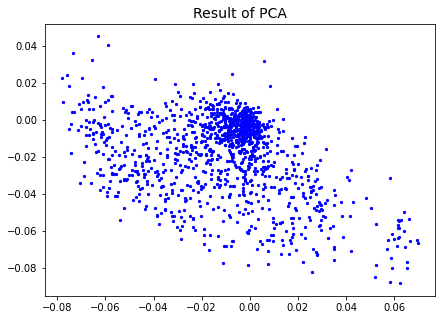

,participant,group-id,n-comments,n-votes,n-agree,n-disagree,0,1,2,3,...,187,188,189,190,191,192,193,194,195,196
0,0,0.0,46,101,44,12,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1.0,0,29,14,10,1.0,-1.0,-1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1.0,5,88,58,15,1.0,-1.0,-1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,1.0,0,31,13,16,1.0,-1.0,-1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,1.0,0,11,0,0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1257,4537,1.0,0,18,10,8,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1258,4579,1.0,0,7,6,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1261,4661,1.0,0,18,5,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1265,958,1.0,0,13,7,4,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [97]:

coords, explained_variance = polis_pca(vals_all_in, 4)
print("Explained variance:", explained_variance)

show_embedding(coords, "blue", "Result of PCA")

# grouped_embed = KMeans(n_clusters=2, random_state=0).fit(coords)
# labs = grouped_embed.labels_

# A_key = np.where(labs == 0 )[0]
# B_key = np.where(labs == 1 )[0]
# print(len(A_key), len(B_key))
grouped_df = kmean_get_grouped(data=vals_all_in, embeds=coords)
grouped_df[0]

Explained variance: [9.99995896e-01 8.52952198e-07 4.44645023e-07 1.09294062e-07]


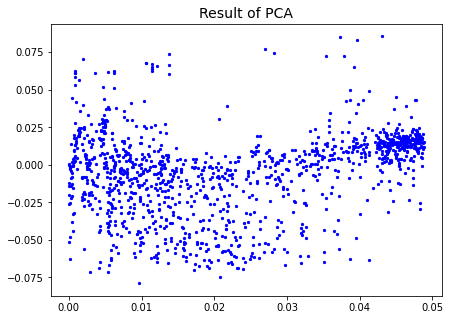

702 567


In [98]:

coords, explained_variance = polis_pca(vals, 4)
print("Explained variance:", explained_variance)

show_embedding(coords, "blue", "Result of PCA")

grouped_embed = KMeans(n_clusters=2, random_state=0).fit(coords)
labs = grouped_embed.labels_

A_key = np.where(labs == 0 )[0]
B_key = np.where(labs == 1 )[0]
print(len(A_key), len(B_key))

## UMAP *Uniform manifold approximation and projection*

Pros:
- Non-linear reduction that is computationally faster than t-SNE
- User defined parameter for preserving local or global structure 
- Solid theoretical foundations in manifold learning 

Cons:
- New, less prevalent algorithm.
- Requires setting hyperparameters that influence quality of the embedding 
- Non-deterministic algorithm. 

In [99]:
def polis_umap(dataframe, neighbors):
    reducer = umap.UMAP(
        n_neighbors=neighbors,
        metric=sparsity_aware_dist,
        init='random',
        min_dist=0.1,
        spread=1.0,
        local_connectivity=1.0,
    )
    embedding = reducer.fit_transform(dataframe.values)
    # embedding.shape
    
    return embedding

/usr/local/lib/python3.8/dist-packages/umap/umap_.py:1772: UserWarning: custom distance metric does not return gradient; inverse_transform will be unavailable. To enable using inverse_transform method, define a distance function that returns a tuple of (distance [float], gradient [np.array])
  warn(


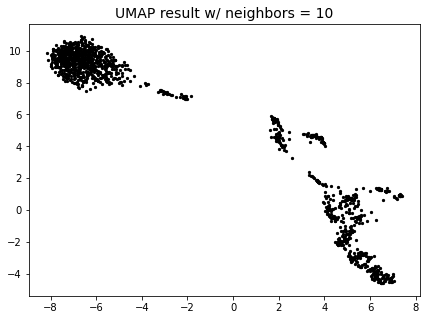

/usr/local/lib/python3.8/dist-packages/umap/umap_.py:1772: UserWarning: custom distance metric does not return gradient; inverse_transform will be unavailable. To enable using inverse_transform method, define a distance function that returns a tuple of (distance [float], gradient [np.array])
  warn(


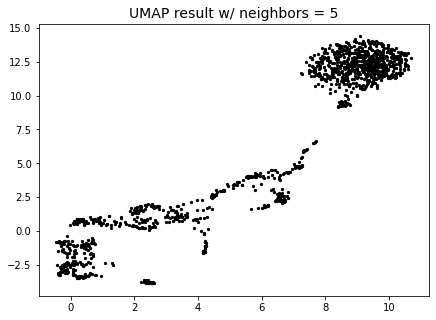

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.8/dist-packages/matplotlib/pyplot.py'>

In [100]:
embedding = polis_umap(vals, 10) 
show_embedding(embedding, "black", "UMAP result w/ neighbors = 10")

embedding = polis_umap(vals, 5) 
show_embedding(embedding, "black", "UMAP result w/ neighbors = 5")


/usr/local/lib/python3.8/dist-packages/umap/umap_.py:1772: UserWarning: custom distance metric does not return gradient; inverse_transform will be unavailable. To enable using inverse_transform method, define a distance function that returns a tuple of (distance [float], gradient [np.array])
  warn(


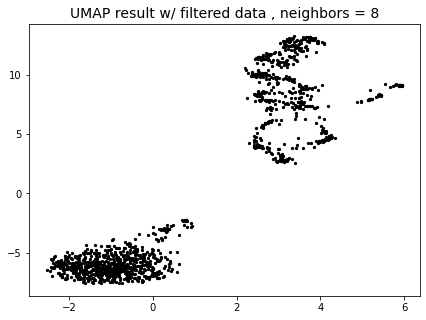

709 318


In [101]:
embedding = polis_umap(vals, 8) 
show_embedding(embedding, "black", "UMAP result w/ filtered data , neighbors = 8")

grouped_embed = KMeans(n_clusters=3
                       , random_state=0).fit(embedding)
labs = grouped_embed.labels_

A_key = np.where(labs == 0 )[0]
B_key = np.where(labs == 1 )[0]
print(len(A_key), len(B_key))

/usr/local/lib/python3.8/dist-packages/umap/umap_.py:1772: UserWarning: custom distance metric does not return gradient; inverse_transform will be unavailable. To enable using inverse_transform method, define a distance function that returns a tuple of (distance [float], gradient [np.array])
  warn(


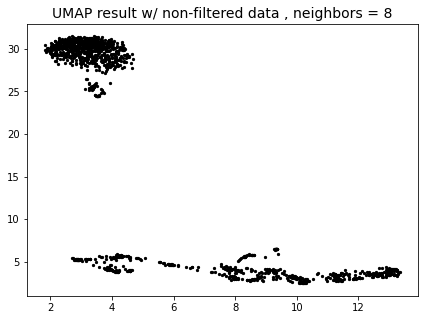

710 559


In [102]:
embedding = polis_umap(vals_all_in, 8) 
show_embedding(embedding, "black", "UMAP result w/ non-filtered data , neighbors = 8")

grouped_embed = KMeans(n_clusters=2, random_state=0).fit(embedding)
labs = grouped_embed.labels_

A_key = np.where(labs == 0 )[0]
B_key = np.where(labs == 1 )[0]
print(len(A_key), len(B_key))

## time series 

In [103]:
df_comments.sort_values('datetime')

,timestamp,datetime,comment-id,author-id,agrees,disagrees,moderated,comment-body,comment-en
167,1435654192077,2015-06-30 15:49:52,0,0,502,187,1,我有用過 Uber 叫車。,I have used Uber to call a car.
166,1435654296727,2015-06-30 15:51:36,3,0,555,152,1,我覺得尖峰時段可以彈性提高收費。,I think it can increase the charges elasticity...
172,1435654422024,2015-06-30 15:53:42,4,0,474,179,1,我覺得應該開放司機同時接受多家派遣。,I think the driver should be opened at the sam...
171,1435654449781,2015-06-30 15:54:09,5,0,385,245,1,我覺得主動取締白牌車是交通部的責任。,I think it is the responsibility of the Minist...
170,1435654477147,2015-06-30 15:54:37,6,0,429,236,1,我覺得載客的車子上應該要有明確標示。,I think there should be clear marks on the car...
...,...,...,...,...,...,...,...,...,...
132,1440694221425,2015-08-27 23:50:21,170,3679,28,42,1,以前是車行管司機，現在是車隊管司機。所以品牌車隊大家比較有信心搭乘，因為有在管理。現在車行不...,"It used to be a driver of the car dealer, and ..."
133,1440709992241,2015-08-28 04:13:12,171,3691,44,62,1,我覺得UBER避稅很正常，就如同你在申報所得稅時會選擇最低金額的申報方式一樣正常。,"I think Uber avoidance is normal, just as you ..."
134,1440710706161,2015-08-28 04:25:06,172,3691,81,13,1,我覺得UBER與計程車車隊的評分系統最大差別是：UBER的評分系統公開透明且貫徹執行，分數低...,I think the biggest difference between Uber an...
142,1440864144461,2015-08-29 23:02:24,173,3805,47,35,1,不應該限制計程車的車輛顏色外觀式樣內裝等等，再好的車噴成黃色很難看，圖利特定廠商而且造成購車...,It should not be limited to the color appearan...


In [104]:
df_comments = df_comments.sort_values('datetime').reset_index(drop=True)
first_cmt_time = df_comments.datetime[0]
last_cmt_time = df_comments.datetime.iloc[-1]
last_cmt_time - first_cmt_time

Timedelta('60 days 14:17:17')

In [105]:

def get_time_limited_cmt_vals(begin_time, period ):

    end_time = begin_time + pd.Timedelta(str(period) +" days")

    cmd_idx = df_comments[(df_comments.datetime>=begin_time) & (df_comments.datetime<=end_time)]["comment-id"]
    cmd_idx = list(cmd_idx.astype(str))

    # use the intersection of vals_all_in's columns(filterd comment list) and time filtered comments
    cmd_idx = [itm for itm in cmd_idx if itm in vals_all_in.columns]
    
    subset_vals = vals_all_in[cmd_idx]
    subset_vals = subset_vals.loc[~(subset_vals==0).all(axis=1)]
    
    return subset_vals

In [106]:
def first_Ndays_umap_graph(days, n=5, show=False):

    subset_vals = get_time_limited_cmt_vals(first_cmt_time, days)
    # print(subset_vals.shape)
    embedding = polis_umap(subset_vals, n) 
    
    if show:
        show_embedding(embedding, "black", "first " +str(days) +" days' UMAP, neighbors = "+str(n))

    return embedding

trail

In [107]:
def dis_umap_graph(embeding):
    
    km = KMeans(n_clusters=2, random_state=3046).fit(embedding)
    print(km.cluster_centers_[0], km.cluster_centers_[1])
    dist = math.dist(km.cluster_centers_[0], km.cluster_centers_[1])
    return dist

In [108]:
vals_all_in.to_numpy()

array([[ 1.,  1.,  1., ...,  1., -1., -1.],
       [ 1.,  1.,  1., ...,  0.,  0.,  0.],
       [ 1.,  1.,  1., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  1.,  0.,  0.],
       [ 0.,  0.,  0., ...,  1.,  0.,  0.]])

In [109]:
for i in range(5):
    # embedding = polis_umap(vals_all_in, 5) 
    # show_embedding(embedding, "black", "UMAP, neighbors = 5")

    # grouped_embed = KMeans(n_clusters=2, random_state=0).fit(embedding)
    # labs = grouped_embed.labels_
    print(dis_umap_graph(vals_all_in.to_numpy()))

[8.554736  4.0342617] [ 3.2004757 29.578444 ]
26.099297499221134
[8.554736  4.0342617] [ 3.2004757 29.578444 ]
26.099297499221134
[8.554736  4.0342617] [ 3.2004757 29.578444 ]
26.099297499221134
[8.554736  4.0342617] [ 3.2004757 29.578444 ]
26.099297499221134
[8.554736  4.0342617] [ 3.2004757 29.578444 ]
26.099297499221134


(1165, 15)


/usr/local/lib/python3.8/dist-packages/umap/umap_.py:1772: UserWarning: custom distance metric does not return gradient; inverse_transform will be unavailable. To enable using inverse_transform method, define a distance function that returns a tuple of (distance [float], gradient [np.array])
  warn(


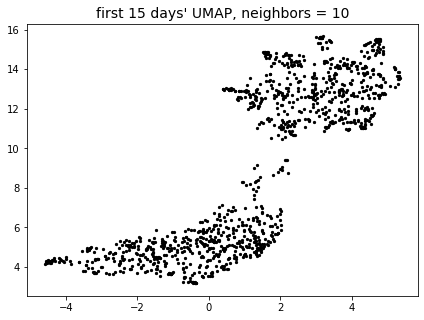

(1238, 76)


/usr/local/lib/python3.8/dist-packages/umap/umap_.py:1772: UserWarning: custom distance metric does not return gradient; inverse_transform will be unavailable. To enable using inverse_transform method, define a distance function that returns a tuple of (distance [float], gradient [np.array])
  warn(


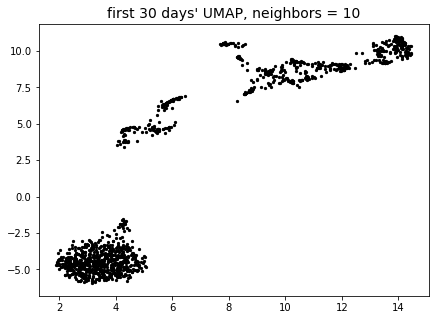

(1239, 80)


/usr/local/lib/python3.8/dist-packages/umap/umap_.py:1772: UserWarning: custom distance metric does not return gradient; inverse_transform will be unavailable. To enable using inverse_transform method, define a distance function that returns a tuple of (distance [float], gradient [np.array])
  warn(


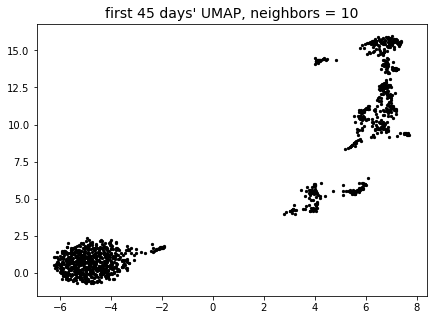

(1242, 97)


/usr/local/lib/python3.8/dist-packages/umap/umap_.py:1772: UserWarning: custom distance metric does not return gradient; inverse_transform will be unavailable. To enable using inverse_transform method, define a distance function that returns a tuple of (distance [float], gradient [np.array])
  warn(


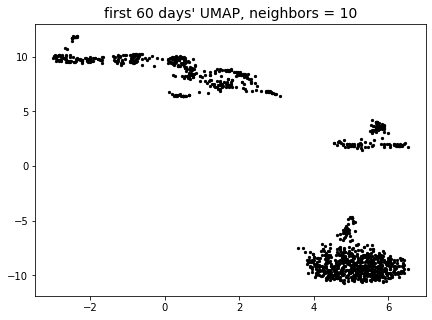

In [110]:
for i in range(15,75,15):
    embedding = first_Ndays_umap_graph(i, 10, True)
    # vals_subset = get_time_limited_cmt_vals(first_cmt_time, i)
    # print(vals_subset.shape)
    # print(dis_umap_graph(vals_subset.to_numpy()))

## show grouped df

用kmeans cluster 的結果去回抓哪些位置的直在不同組，在透過那些組回去vals_all_in df 找到他們的在主要df 的index在拿到他們的participant_id

In [111]:
A_key = np.where(grouped_embed.labels_ == 0 )[0]
B_key = np.where(grouped_embed.labels_ == 1 )[0]
A_idx = np.take(vals_all_in.index.to_numpy(), A_key)
B_idx = np.take(vals_all_in.index.to_numpy(), B_key)
A_participants = df.filter(items = A_idx, axis=0)
B_participants = df.filter(items = B_idx, axis=0)

In [112]:
# get the vote rate, agree rate, disagree rate of opinion group A and B on each commment 
# https://sheethub.com/au/participants-votes-with-group-id.csv#detail: According to the source, "-1" represents agree, "1" represents disagree, "0" represents skip

metadata_fields = ['participant', 'group-id', 'n-comments', 
                   'n-votes', 'n-agree','n-disagree']
val_fields = [c for c in A_participants.columns.values if c not in metadata_fields]
A_participants_val = A_participants[val_fields]
A_participants_val_T = A_participants_val.transpose()
# print(A_participants_val_T.value_counts())
# A_participants_val_T['a_agree'] = 
# A_participants_val_T['a_disagree'] = 
# A_vote

# df['Sum']=df.iloc[:,1:3].sum(axis=1)

In [113]:

A_participants_val_T['a_disagree'] = np.count_nonzero(A_participants_val_T.to_numpy() == -1, axis=1)
A_participants_val_T['a_agree'] = np.count_nonzero(A_participants_val_T.to_numpy() == 1, axis=1)

In [114]:
A_participants_val_T['a_support']= (A_participants_val_T['a_agree']-A_participants_val_T['a_disagree'])
A_participants_val_T['a_support_share']= (A_participants_val_T['a_agree']-A_participants_val_T['a_disagree'])/(A_participants_val_T['a_agree']+A_participants_val_T['a_disagree'])
A_support_arguments = A_participants_val_T.sort_values(by=['a_support'], ascending=False).head(10)
A_against_arguments = A_participants_val_T.sort_values(by=['a_support']).head(10)

In [115]:
A_participants_val_T = A_participants_val_T.reset_index()
A_participants_val_T1 = A_participants_val_T[["index","a_disagree","a_agree","a_support_share","a_support"]]

In [116]:
B_participants_val = B_participants[val_fields]
B_participants_val_T = B_participants_val.transpose()
B_participants_val_T['b_disagree'] = np.count_nonzero(B_participants_val_T.to_numpy() == -1, axis=1)
B_participants_val_T['b_agree'] = np.count_nonzero(B_participants_val_T.to_numpy() == 1, axis=1)


In [117]:
B_participants_val_T = B_participants_val_T.reset_index()
B_participants_val_T['b_support']= (B_participants_val_T['b_agree']-B_participants_val_T['b_disagree'])
B_participants_val_T['b_support_share']= (B_participants_val_T['b_agree']-B_participants_val_T['b_disagree'])/(B_participants_val_T['b_agree']+B_participants_val_T['b_disagree'])
B_support_arguments = B_participants_val_T.sort_values(by=['b_support'], ascending=False).head(10)
B_against_arguments = B_participants_val_T.sort_values(by=['b_support']).head(10)
B_participants_val_T1= B_participants_val_T[["index","b_disagree","b_agree","b_support_share","b_support"]]


In [118]:
joint_participants_val_T1 = A_participants_val_T1.merge(B_participants_val_T1, on = "index")
joint_participants_val_T1['difference']=joint_participants_val_T1['a_support']-joint_participants_val_T1['b_support']
joint_participants_val_T1['difference_pct']=joint_participants_val_T1['a_support_share']-joint_participants_val_T1['b_support_share']

joint_participants_val_T1_filtered = joint_participants_val_T1[joint_participants_val_T1['a_agree']+joint_participants_val_T1['a_disagree'] >= 5]
joint_participants_val_T1_filtered = joint_participants_val_T1[joint_participants_val_T1['b_agree']+joint_participants_val_T1['b_disagree'] >= 5]

dispute_arguments = joint_participants_val_T1_filtered.sort_values(by=['difference'], ascending=False, key = abs).head(5)
consensus_arguments = joint_participants_val_T1_filtered.sort_values(by=['difference'], ascending=True, key = abs).head(5)

dispute_arguments_1 = joint_participants_val_T1_filtered.sort_values(by=['difference_pct'], ascending=False, key = abs).head(5)
consensus_arguments_1 = joint_participants_val_T1_filtered.sort_values(by=['difference_pct'], ascending=True, key = abs).head(5)

In [119]:
dispute_arguments_df = dispute_arguments.merge(df_comments, left_index = True, right_on = 'comment-id', how = 'left')

In [120]:
dispute_arguments_df[["comment-id", "author-id", "a_agree", "a_disagree", "a_support_share", "b_agree", "b_disagree", "b_support_share", "comment-body"]]

,comment-id,author-id,a_agree,a_disagree,a_support_share,b_agree,b_disagree,b_support_share,comment-body
13,16,0,266,18,0.873239,398,14,0.932039,我覺得 UberX 自用車載客時，應該要投保汽車乘客責任險。
0,0,0,169,70,0.414226,312,113,0.468235,我有用過 Uber 叫車。
11,14,0,199,32,0.722944,324,61,0.683117,我有小型車駕駛執照。
7,9,0,206,54,0.584615,309,63,0.661290,我覺得 Uber 平台的爭端解決紀錄應呈報給交通部。
12,15,0,101,123,-0.098214,125,241,-0.316940,我有職業駕照。


In [121]:
dispute_arguments_1_df = dispute_arguments_1.merge(df_comments, left_index = True, right_on = 'comment-id', how = 'left')

In [122]:
dispute_arguments_1_df[["comment-id", "author-id", "a_agree", "a_disagree", "a_support_share", "b_agree", "b_disagree", "b_support_share", "comment-body"]]

,comment-id,author-id,a_agree,a_disagree,a_support_share,b_agree,b_disagree,b_support_share,comment-body
NaN,2,NaN,2,2,0.000000,0,5,-1.000000,NaN
NaN,1,NaN,1,2,-0.333333,0,5,-1.000000,NaN
94.0,170,3679.0,15,12,0.111111,8,23,-0.483871,以前是車行管司機，現在是車隊管司機。所以品牌車隊大家比較有信心搭乘，因為有在管理。現在車行不...
90.0,162,1065.0,16,6,0.454545,16,12,0.142857,就駕駛而言，計程車司機的收入比uber好，uber司機收入是計程車車資六成。
95.0,171,3691.0,19,33,-0.269231,19,19,0.000000,我覺得UBER避稅很正常，就如同你在申報所得稅時會選擇最低金額的申報方式一樣正常。


In [123]:
consensus_arguments_1_df = consensus_arguments_1.merge(df_comments, left_index = True, right_on = 'comment-id', how = 'left')

In [124]:
consensus_arguments_1_df[["comment-id", "author-id", "a_agree", "a_disagree", "a_support_share", "b_agree", "b_disagree", "b_support_share", "comment-body"]]

,comment-id,author-id,a_agree,a_disagree,a_support_share,b_agree,b_disagree,b_support_share,comment-body
84,154,3120,36,18,0.333333,32,16,0.333333,我覺得UberX在計費上，晚上應該費用能提高，不能以低價只為了乘客，卻讓司機無力持續，造成車...
33,46,0,222,35,0.727626,297,47,0.726744,我覺得類似共乘，但由開車的人向共乘者收費的概念，是可行的。
44,65,0,230,18,0.854839,276,22,0.852349,我覺得政府應該對運輸業設置公平的管制規則，而不是保護特定的既得利益者。
22,31,0,86,114,-0.140000,145,191,-0.136905,我覺得既然交通部已駁回 Uber 的行政訴願，台北市政府就應該註銷「台灣宇博數位」的公司登記。
52,78,0,131,91,0.180180,141,99,0.175000,我覺得搭乘他人的自用車，若是無從判斷此人是否通過測驗及健檢，感覺非常沒有保障。
